In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time as time
import pandas as pd
import math

colorsBlue = ['#b3e5fc', '#0091ea']
colorsRed = ['#f18e86', '#e83b47']
colorsYellow = ['#fec787', '#fb9d32']
colorsPurple = ['#d69bc5' ,'#a8509f']
colorsGreyOrange = ['#c3c3c3', '#f8a834']
colors = [colorsBlue, colorsRed, colorsYellow, colorsPurple, colorsGreyOrange]

In [2]:
from utils.modules import net
import os

In [ ]:
t_train = 400
t_test = 400
norm = 10
folder = 'sweep_chaos_res'

In [ ]:
# generate ensemble of 135 chaotic trajectories, at a sampling rate equal to FORCE simulation step (dt = 0.01)
# this cell requires the dysts library, install via
# pip install git+https://github.com/williamgilpin/dysts

# the resulting .npy file is too big to be included

In [1]:
# from dysts.systems import make_trajectory_ensemble
# 
# t0 = time.time()
# # generate set of chaotic attractors, with period ~ 20, so 20 periods for training and 1 for testing
# TT = np.arange(0, t_train + t_test, 0.01)
# all_out = make_trajectory_ensemble(len(TT), resample=True, pts_per_period = 2000, use_multiprocessing = True)
# print(time.time() - t0)
# 
# with open('data/sweep_chaos_target.npy', 'wb') as f:
#     np.save(f, TT)
#     np.save(f, all_out)

In [4]:
with open('data/sweep_chaos_target.npy', 'rb') as f:
    TT = np.load(f, allow_pickle=True)
    all_out = np.load(f, allow_pickle=True).item()

In [5]:
ChaosTrajs = []
for i, attractor_name in enumerate(all_out):
    sol = all_out[attractor_name]
    sol = sol[:, 0]
    sol -= np.mean(sol)
    sol /= np.std(sol)
    ChaosTrajs.append(norm * sol)
ChaosTrajs = np.array(ChaosTrajs)

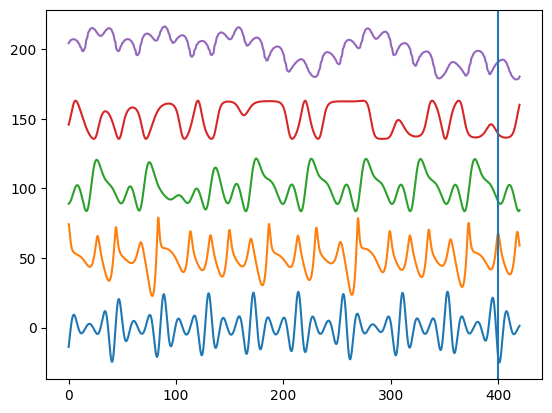

In [10]:
plt.figure()
for i in range(5):
    plt.plot(ChaosTrajs[i][:10000] + i * 40)
# plt.savefig('run_sweep_chaos_traj.pdf')

In [7]:
class chaoticsys:
    def __init__(self, index):
        self.cur_time_point = 0
        self.traj = ChaosTrajs[index]
        
    def step(self, t):
        self.cur_time_point += 1
        return self.traj[self.cur_time_point - 1]

In [8]:
def run_one(inputs):
    [seed, sys_idx, algo_idx] = inputs
    save_name = f'data/{folder}/traj-{sys_idx:03d}_algo-{algo_idx:02d}.csv'
    if os.path.isfile(save_name):
        pass
    else:
        gamma = 0.002 * algo_idx
        network = net(seed = seed)
        sys = chaoticsys(sys_idx)
        RES_TR = network.simulate_train(t_train, sys.step, γ = gamma)
        RES_TE = network.simulate_test(t_train + t_test, sys.step, t_ini = t_train)
    
        # downsample - otherwise there is too much data
        TT = np.array([*RES_TR[0], *RES_TE[0]])[::10]
        ZZ = np.array([*np.reshape(RES_TR[4], -1), *np.reshape(RES_TE[4], -1)])[::10]
        EE = np.array([*np.reshape(RES_TR[5], -1), *np.reshape(RES_TE[5], -1)])[::10]
        df = pd.DataFrame({'T' : TT, 'Z' : ZZ, 'E' : EE})
        df.to_csv(save_name, index = False)

In [ ]:
from multiprocessing import Pool

if __name__ == '__main__':
    
    pool = Pool()
    INPUTS = []
    seed = 0
    for sys_idx in range(len(ChaosTrajs)):
        for algo_idx in range(2):
            INPUTS.append([seed, sys_idx, algo_idx])
            seed += 1

    pool.map(run_one, INPUTS, chunksize = 1)
    pool.terminate()

In [ ]:
cuts = [380, 400, 405]
MSE = np.zeros((len(ChaosTrajs), 2, len(cuts) - 1))
for c in range(len(cuts) - 1):
    for i in range(len(ChaosTrajs)):
        for j in range(2):
            df = pd.read_csv(f'data/{folder}/traj-{i:03d}_algo-{j:02d}.csv')
            t0 = cuts[c]
            t1 = cuts[c+1]
            MSE[i,j,c] = np.sqrt(np.mean(df['E'].values[int(t0 * 10):int(t1 * 10)] ** 2)) / norm
            print(f'{i}-{j}-{c}', end = '\r')

In [ ]:
fig, axes = plt.subplots(1, len(cuts) - 1, sharex = True, sharey = True, figsize = (6, 3))
for i in range(len(cuts) - 1):
    axes[i].scatter(MSE[:, 0, i], MSE[:, 1, i], s = 5, color = colors[0][i])
    axes[i].plot([0, 100], [0, 100], color = 'black')
    axes[i].set_aspect(1)
    axes[i].axhline(1, color = 'black', linestyle = 'dashed')
    axes[i].axvline(1, color = 'black', linestyle = 'dashed')
axes[0].set_xlabel('FORCE error')
axes[1].set_xlabel('FORCE error')
axes[0].set_ylabel('forgetful FORCE error')
axes[0].set_xscale('log')
axes[0].set_yscale('log')

axes[0].set_xlim(1e-4, 1e2)
axes[0].set_ylim(1e-4, 1e2)

In [ ]:
sorted_idx = np.argsort(MSE[:, 1, 1] / MSE[:, 0, 1])
best_idx = sorted_idx[0]
worst_idx = sorted_idx[-1]
print(sorted_idx)

In [ ]:
fig, axes = plt.subplots(2, 1, figsize = (4, 4), sharex = True, sharey = True)

sys_idx = best_idx
for i in range(2):
    df = pd.read_csv(f'data/sweep_chaos_res/traj-{sys_idx:03d}_algo-{i:02d}.csv')
    axes[i].plot(df['T'], df['Z'], color = colors[4][1])
    axes[i].plot(df['T'], ChaosTrajs[sys_idx][::10], color = colors[4][0], zorder = -5)

axes[0].set_xlim(360, 440)
axes[0].set_ylim(-50, 50)
plt.savefig('run_sweep_chaos_GOOD.pdf')
fig, axes = plt.subplots(2, 1, figsize = (4, 4), sharex = True, sharey = True)

sys_idx = worst_idx
for i in range(2):
    df = pd.read_csv(f'data/sweep_chaos_res/traj-{sys_idx:03d}_algo-{i:02d}.csv')
    axes[i].plot(df['T'], df['Z'], color = colors[4][1])
    axes[i].plot(df['T'], ChaosTrajs[sys_idx][::10], color = colors[4][0], zorder = -5)

axes[0].set_xlim(360, 440)
axes[0].set_ylim(-50, 50)

In [ ]:
fig, axes = plt.subplots(1, len(cuts) - 1, sharex = True, sharey = True, figsize = (6, 3))
for i in range(len(cuts) - 1):
    axes[i].scatter(MSE[best_idx, 0, i], MSE[best_idx, 1, i], s = 10, color = colors[0][i])
    axes[i].scatter(MSE[worst_idx, 0, i], MSE[worst_idx, 1, i], s = 10, color = colors[1][i])
    axes[i].plot([0, 100], [0, 100])
    axes[i].set_aspect(1)

axes[0].set_xlabel('FORCE error')
axes[1].set_xlabel('FORCE error')
axes[0].set_ylabel('forgetful FORCE error')
axes[0].set_xscale('log')
axes[0].set_yscale('log')

axes[0].set_xlim(1e-4, 1e2)
axes[0].set_ylim(1e-4, 1e2)